### Importieren benötigter Bibliotheken

In [1]:
from __future__ import print_function, division
from sympy import symbols, simplify, trigsimp
from sympy.physics.mechanics import dynamicsymbols, ReferenceFrame, Point
from sympy.physics.mechanics import inertia, RigidBody, KanesMethod
from sympy.physics.vector import init_vprinting
init_vprinting(use_latex='mathjax', pretty_print=False)

# 1. Kinematik

### Koordinatensysteme / Bezugssysteme

In [2]:
# Initialisieren der benötigten Koordinatensysteme
inertial_frame = ReferenceFrame('I')
print(type(inertial_frame))
print(inertial_frame)
pendulum1_frame = ReferenceFrame('P_1')
print(type(pendulum1_frame))
print(pendulum1_frame)

<class 'sympy.physics.vector.frame.ReferenceFrame'>
I
<class 'sympy.physics.vector.frame.ReferenceFrame'>
P_1


### Orientierung und Zwangsbedingungen an den Koordinatensystemen

In [3]:
theta1 = dynamicsymbols('theta1')
print(type(theta1))
print(theta1)

theta1
theta1(t)


In [4]:
# Zwangsbedingung des Bezugssystems P1 zum Inertialsystem:
# setze fest, dass pendulum1 lediglich um die z-Achse des Inertalsystems rotieren kann, um den Winkel theta1
pendulum1_frame.orient(inertial_frame, 'Axis', (theta1, inertial_frame.z))

In [5]:
# Daraus ergibt sich dann, dass die die Position von pendulum1 mit der folgenden Rotationsmatrix berechnet werden kann:
pendulum1_frame.dcm(inertial_frame)

Matrix([
[ cos(theta1), sin(theta1), 0],
[-sin(theta1), cos(theta1), 0],
[           0,           0, 1]])

<p> Multipliziert man diese Rotationsmatrix mit einem Vektor, lässt sich damit der Vektor um die entsprechenden Winkel zum Inertialsystem drehen</p>

### Massepunkte und Gelenkpunkte

In [6]:
# Zunächst setzen wir einen fixen Ankerpunkt im Inertialsystem
ankle = Point('A')

In [7]:
# setzen unseren zweiten Punkt, der später pendulum1 und pendulum2 verbinden soll
p1 = Point('P_1')

In [8]:
# definieren nun eine Länge für unser erstes Pendel
pendulum1_length = symbols('l_1')

In [9]:
# Die Position des Punktes P lässt sich jetzt über die Länge l1 * der Richtung y des Bezugssystems P beschreiben
p1.set_pos(ankle, pendulum1_length * pendulum1_frame.y)

# Durch die Multiplikation mit der Rotationsmatrix zwischen dem Inertialsystems und Pendulum1 kann der Punkt P
# im Bezug zum Inertialsystem beschrieben werden
p1.pos_from(ankle).express(inertial_frame).simplify()

- l_1*sin(theta1)*I.x + l_1*cos(theta1)*I.y

<p>Da wir nicht mit masselosen Pendeln rechnen wollen, müssen wir außerdem die Massenschwerpunkte unserer Pendel angeben</p>

In [10]:
# wir machen dies analog zur Vorgehensweise der Gelenkpunkte
pendulum1_mass_length = symbols('l_m1')
pendulum1_mass_center = Point('P_m1')
pendulum1_mass_center.set_pos(ankle, pendulum1_mass_length * pendulum1_frame.y)

### Aufstellen der Differentialgleichungen

In [11]:
# Wir benötigen die Winkelgeschwindigkeiten
omega1 = dynamicsymbols('omega1')

# Diese sind genauso groß, wie die Ableitung des Winkels Theta1 nach der Zeit --> 𝜔 = 𝜃˙
# Diese Formulierung müssen wir tätigen, da wir unsere Bewegungsgleichung nach Kanes-Methode aufstellen.
# Zudem benötigen alle numerischen Integratoren eine DGL 1.Ordnung
kinematical_differential_equations = [omega1 - theta1.diff()]
kinematical_differential_equations

[omega1 - theta1']

In [12]:
# Die erste Winkelgeschwindigkeit rotiert um die Z-Achse unseres Inertialsystems
pendulum1_frame.set_ang_vel(inertial_frame, omega1*inertial_frame.z)
pendulum1_frame.ang_vel_in(inertial_frame)

omega1*I.z

In [13]:
# Der Ankerpunkt am Inertialsystem wird raumfest mit der Geschwindigkeit 0 angenommen 
ankle.set_vel(inertial_frame, 0)

# 2. Massenträgheiten

### Massenträgheiten

In [14]:
pendulum1_mass = symbols('m_1')

In [15]:
pendulum1_inertia = symbols('I_p1')

In [16]:
help(inertia)

Help on function inertia in module sympy.physics.mechanics.functions:

inertia(frame, ixx, iyy, izz, ixy=0, iyz=0, izx=0)
    Simple way to create inertia Dyadic object.
    
    Explanation
    
    If you don't know what a Dyadic is, just treat this like the inertia
    tensor. Then, do the easy thing and define it in a body-fixed frame.
    
    Parameters
    
    frame : ReferenceFrame
        The frame the inertia is defined in
    ixx : Sympifyable
        the xx element in the inertia dyadic
    iyy : Sympifyable
        the yy element in the inertia dyadic
    izz : Sympifyable
        the zz element in the inertia dyadic
    ixy : Sympifyable
        the xy element in the inertia dyadic
    iyz : Sympifyable
        the yz element in the inertia dyadic
    izx : Sympifyable
        the zx element in the inertia dyadic
    
    Examples
    
    >>> from sympy.physics.mechanics import ReferenceFrame, inertia
    >>> N = ReferenceFrame('N')
    >>> inertia(N, 1, 2, 3)
    (N.x|

In [17]:
# Das Dyadsiche Produkt ermöglicht uns das speichern der Trägheit als Tensor in Abhängigkeit zum Bezugssystem
pendulum1_inertia_dyadic = inertia(pendulum1_frame, 0, 0, pendulum1_inertia)
pendulum1_inertia_dyadic

I_p1*(P_1.z|P_1.z)

In [18]:
pendulum1_inertia_dyadic.to_matrix(pendulum1_frame)

Matrix([
[0, 0,    0],
[0, 0,    0],
[0, 0, I_p1]])

In [19]:
pendulum1_central_inertia = (pendulum1_inertia_dyadic, pendulum1_mass_center)

In [20]:
# Eine komplette Beschreibung des Rigid Bodys besteht aus: Massenschwerpunkt, Bezugssystem, Masse und Trägheit
pendulum1 = RigidBody('Pendulum 1', pendulum1_mass_center, pendulum1_frame,
                      pendulum1_mass, pendulum1_central_inertia)

# 3. Kinetik (extern aufgeprägte Kräfte)

In [21]:
g = symbols('g')

In [22]:
pendulum1_grav_force_vector = -pendulum1_mass * g * inertial_frame.y
pendulum1_grav_force_vector

- g*m_1*I.y

In [23]:
# Die Gravitationskraft legen wir immer mit -y Richtung unseres Inertialsystems an
pendulum1_grav_force = (pendulum1_mass_center, pendulum1_grav_force_vector)

In [24]:
# Zusätzlich könnten wir an unserem Rotations-FHG der Gelenke auch ein Moment aufprägen
ankle_torque, p1_torque = dynamicsymbols('T_a, T_p1')
pendulum1_torque_vector = ankle_torque * inertial_frame.z - p1_torque * inertial_frame.z
pendulum1_torque = (pendulum1_frame, pendulum1_torque_vector)
pendulum1_torque_vector

(T_a - T_p1)*I.z

# 4. Aufstellen der Bewegungsgleichungen

In [25]:
angles = [theta1]
#print(angles)
speeds = [omega1]
# Wir hatten dies bereits im Kapitel 1 - Kinematik definiert
kinematical_differential_equations

[omega1 - theta1']

In [26]:
# Zusammentragen aller von außen aufgeprägten Kräfte
loads = [pendulum1_grav_force,
         pendulum1_torque]
loads

[(P_m1, - g*m_1*I.y), (P_1, (T_a(t) - T_p1(t))*I.z)]

In [27]:
# Wir erinnern uns an die angelegten Starrkörper
bodies = [pendulum1]
bodies

[Pendulum 1]

<p>Die Formulierung der Bewegungsgleichungen nach Kane sieht der bekannten Form nach Newton Euler sehr ähnlich:</p>
<p>Kanes Formulierung: $F_r + F_r^* = 0$</p>
<p>Newton Euler Formulierung: ${F} = {m}{a} \hspace{1cm} {T} = {I}{\alpha}$</p>

In [28]:
print(type(pendulum1))
print(type(pendulum1_grav_force[0]))
print(len(pendulum1_grav_force))
print(type(pendulum1_torque[0]))

kane = KanesMethod(inertial_frame, angles, speeds, kinematical_differential_equations)
fr, frstar = kane.kanes_equations(bodies, loads)

<class 'sympy.physics.mechanics.rigidbody.RigidBody'>
<class 'sympy.physics.vector.point.Point'>
2
<class 'sympy.physics.vector.frame.ReferenceFrame'>


In [29]:
trigsimp(fr + frstar)

Matrix([[g*l_m1*m_1*sin(theta1) - (I_p1 + l_m1**2*m_1)*omega1' + T_a - T_p1]])

In [30]:
mass_matrix = trigsimp(kane.mass_matrix_full)
mass_matrix

Matrix([
[1,                  0],
[0, I_p1 + l_m1**2*m_1]])

In [31]:
forcing_vector = trigsimp(kane.forcing_full)
forcing_vector

Matrix([
[                             omega1],
[g*l_m1*m_1*sin(theta1) + T_a - T_p1]])

### Damit haben wir alle Dinge beisammen:
<p>- Bezugssysteme</p>
<p>- Gelenkpunkte + Zwangsbedingungen</p>
<p>- Massepunkte</p>
<p>- Massenträgheit</p>
<p>- Kinetik (externe Kräfte)</p>
<p>- Formulierung der Bewegungsgleichungen</p>
<p>- Umformen für die Simulation in Massenabhängikeitsmatrix und Kraftabhängigkeitsmatrix als DGL 1.Ordnung $M(x,t)\dot x = f(x,t)$ (x=statevector)</p>

# 5. Lösen der Bewegungsgleichung

In [32]:
from numpy import deg2rad, rad2deg, array, zeros, linspace
from scipy.integrate import odeint
from pydy.codegen.ode_function_generators import generate_ode_function
from matplotlib.pyplot import plot, legend, xlabel, ylabel, rcParams
from sympy.physics.vector import init_vprinting, vlatex
%matplotlib inline
rcParams['figure.figsize'] = (14.0, 6.0)

/Users/lennartfuhrig/opt/anaconda3/lib/python3.8/site-packages/sympy/printing/ccode.py:8: SymPyDeprecationWarning: 

importing from sympy.printing.ccode has been deprecated since SymPy
1.7. Use Import from sympy.printing.c instead. See
https://github.com/sympy/sympy/issues/20256 for more info.

  SymPyDeprecationWarning(


In [33]:
constants = [pendulum1_length,
             pendulum1_mass_length,
             pendulum1_mass,
             pendulum1_inertia,
             g]
constants

[l_1, l_m1, m_1, I_p1, g]

In [34]:
specified = [ankle_torque, p1_torque]

In [35]:
# wir lassen uns die Gleichung nach x' umstellen
right_hand_side = generate_ode_function(forcing_vector, angles,
                                        speeds, constants,
                                        mass_matrix=mass_matrix,
                                        specifieds=specified)

In [36]:
#help(right_hand_side)

In [37]:
# Festlegen der Initialbedingungen für die numerische Lösung der DGL

# Zu Beginn setzen wir beide Geschwindigkeiten auf 0
# und die beiden Winkel versetzen wir nach belieben
x0 = zeros(2)
x0[0] = deg2rad(10)

# Wir setzen nun realistische Werte für unsere Konstanten an
numerical_constants = array([0.8,  # pendulum1_length [m]
                             0.4,  # pendulum1_com_length [m]
                             4.0,  # pendulum1_mass [kg]
                             0.64,  # pendulum1_inertia [kg*m^2]
                             9.81],  # acceleration due to gravity [m/s^2]
                            )

# Wir setzen auch die Gelenkmomente initial auf 0
numerical_specified = array([0, 0])

<p>Mit den bekannten Anfangsbedingungen wollen wir über unseren gewünschten Beobachtungszeitraum numerisch integrieren.</p>
<p>Dazu geben wir dem Solver (z. B. Runge-Kutta) unsere Anfangsbedingungen, die Gleichung für x' und den Zeitraum sowie die Schrittweite t.</p>

In [38]:
frames_per_sec = 30
final_time = 8

t = linspace(0, final_time, final_time * frames_per_sec)

y = odeint(right_hand_side, x0, t, args=(numerical_specified, numerical_constants))

In [39]:
y.shape
print(y)

[[ 0.17453293  0.        ]
 [ 0.17572717  0.07143652]
 [ 0.17932608  0.14384038]
 [ 0.18537836  0.21819078]
 [ 0.19396589  0.29549055]
 [ 0.20520464  0.37677794]
 [ 0.2192461   0.46313823]
 [ 0.23627905  0.55571516]
 [ 0.25653166  0.65572166]
 [ 0.28027402  0.76444977]
 [ 0.30782089  0.8832788 ]
 [ 0.33953475  1.01368093]
 [ 0.37582895  1.15722277]
 [ 0.41717079  1.31556077]
 [ 0.46408436  1.49042784]
 [ 0.5171527   1.68360725]
 [ 0.57701877  1.89688844]
 [ 0.64438466  2.1319987 ]
 [ 0.72000783  2.39050212]
 [ 0.80469348  2.67365631]
 [ 0.89928111  2.9822169 ]
 [ 1.00462361  3.31618059]
 [ 1.12155668  3.67446231]
 [ 1.25085629  4.05451106]
 [ 1.39318258  4.45188712]
 [ 1.54900968  4.85984921]
 [ 1.71854282  5.26903449]
 [ 1.90162807  5.66735045]
 [ 2.09766381  6.04022093]
 [ 2.30552842  6.37131727]
 [ 2.52354142  6.64383232]
 [ 2.74947554  6.84222257]
 [ 2.98063169  6.95416342]
 [ 3.21397743  6.97231559]
 [ 3.44633515  6.89546236]
 [ 3.67459313  6.72870409]
 [ 3.89590615  6.48265423]
 

# 6. Visualisierung

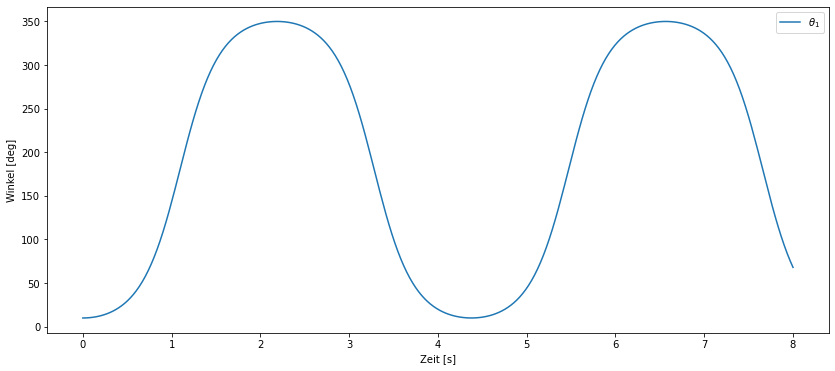

In [40]:
# Darstellung der zwei Winkel über die Simulationsdauer
plot(t, rad2deg(y[:, :1]))
xlabel('Zeit [s]')
ylabel('Winkel [deg]')
legend(["${}$".format(vlatex(c)) for c in angles])

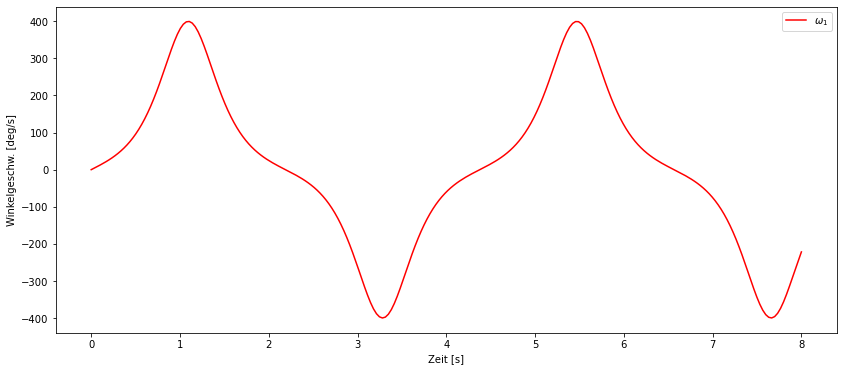

In [41]:
# Darstellung der beiden Geschwindigkeiten über die Simulationsdauer
plot(t, rad2deg(y[:, 1:]), color='r') # siehe y.shape
xlabel('Zeit [s]')
ylabel('Winkelgeschw. [deg/s]')
legend(["${}$".format(vlatex(s)) for s in speeds])

In [42]:
from pydy.viz.shapes import Cylinder, Sphere
import pydy.viz
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz.scene import Scene

# Für die Punkte legen wir schwarze Kugeln an
ankle_shape = Sphere(color='black', radius=0.1)
p1_shape = Sphere(color='black', radius=0.1)

# setzen die erzeugten Geometrien an die Punkte
ankle_viz_frame = VisualizationFrame(inertial_frame, ankle, ankle_shape)
p1_viz_frame = VisualizationFrame(inertial_frame, p1, p1_shape)

# umformen der Konstanten in für das Programm leserliches Format
constants_dict = dict(zip(constants, numerical_constants))

# Setzen der Geometrie für die Starrkörper
pendulum1_center = Point('p1_c')
pendulum1_center.set_pos(ankle, pendulum1_length / 2 * pendulum1_frame.y)

pendulum1_shape = Cylinder(radius=0.08, length=constants_dict[pendulum1_length], color='blue')
pendulum1_viz_frame = VisualizationFrame('Pendulum 1', pendulum1_frame, pendulum1_center, pendulum1_shape)

# Erstellen der Szene mit dem Inertialsystem/Ankerpunkt in der Mitte
scene = Scene(inertial_frame, ankle)

# Laden der Starrkörper in die Szene
scene.visualization_frames = [ankle_viz_frame,
                              p1_viz_frame,
                              pendulum1_viz_frame]

# Darstellung und einfügen der Ergebnisse
scene.states_symbols = angles + speeds
scene.constants = constants_dict
scene.states_trajectories = y

# öffnen der Simulation
scene.display()

/Users/lennartfuhrig/Desktop/Lenny/Uni/Master/1. Semester/SDS/pydy-resources
Serving HTTP on 127.0.0.1 port 8000 ...
To view visualization, open:

http://localhost:8000/index.html?load=2021-11-06_13-41-05_scene_desc.json
Press Ctrl+C to stop server...


127.0.0.1 - - [06/Nov/2021 13:41:06] "GET /index.html?load=2021-11-06_13-41-05_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2021 13:41:06] "GET /2021-11-06_13-41-05_scene_desc.json HTTP/1.1" 200 -
127.0.0.1 - - [06/Nov/2021 13:41:06] code 404, message File not found
127.0.0.1 - - [06/Nov/2021 13:41:06] "GET /fonts/glyphicons-halflings-regular.woff2 HTTP/1.1" 404 -
127.0.0.1 - - [06/Nov/2021 13:41:06] "GET /2021-11-06_13-41-05_simulation_data.json HTTP/1.1" 200 -
